## Name: Tausif Solaiman

## Project Description: 
### The purpose of this project is to gather data about a NBA player's made/missed shots during the season using data from the NBA API and create visualizations using Matplotlib. The Visualizations can be used to study the strengths and weaknesses of a player and formulate strategies for future games. 

In [2]:
import numpy as np
import pandas as pd

#nba_api
from nba_api.stats.endpoints import shotchartdetail
from nba_api.stats.static import players
from nba_api.stats.endpoints import playercareerstats


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import cm
from matplotlib.patches import Circle, Rectangle, Arc, Polygon, ConnectionPatch
from matplotlib.collections import PatchCollection
from matplotlib.colors import LinearSegmentedColormap, ListedColormap, BoundaryNorm

# Part 1/2/3 Web Scraping / Numpy&Pandas / Data Combine Merge

## Get Data about a players made shots for every game in the regular season

In [48]:
def get_player_shotchartdetail(player_name, season_id):
    
  #WEB SCRAPING 
  nba_players = players.get_players()    
  #create player dictionary
  player_dict = [player for player in nba_players if player['full_name'] == player_name][0]
  # Gets player career stats using the dictionary of the player created by passing in stored id
  career = playercareerstats.PlayerCareerStats(player_id=player_dict['id'])
    

  # get_data_frames method provided by the API
  #career dataframe
  career_df = career.get_data_frames()[0]

  #Get team id for the seaon passed into the function
  team_id = career_df[career_df['SEASON_ID'] == season_id]['TEAM_ID']


  #make json request
  #No need to load the json request into a pandas object, and turn it into a dataframe bc of get_data_frames()
  shotchartlist = shotchartdetail.ShotChartDetail(team_id=team_id,
  player_id=player_dict['id'],
  season_type_all_star = 'Regular Season',
  season_nullable=season_id,
  context_measure_simple="FGA").get_data_frames()
  print(shotchartlist)


  #Combining relevant datasets (player shot chart detail & League Averages)
  combined_df = pd.concat([shotchartlist[0], shotchartlist[1]])
 
  #return shot chart of player and league averages
  return shotchartlist[0], shotchartlist[1]

get_player_shotchartdetail("LeBron James", "2019-20")

[              GRID_TYPE     GAME_ID  GAME_EVENT_ID  PLAYER_ID   PLAYER_NAME  \
0     Shot Chart Detail  0021900002              7       2544  LeBron James   
1     Shot Chart Detail  0021900002             21       2544  LeBron James   
2     Shot Chart Detail  0021900002             59       2544  LeBron James   
3     Shot Chart Detail  0021900002            129       2544  LeBron James   
4     Shot Chart Detail  0021900002            187       2544  LeBron James   
...                 ...         ...            ...        ...           ...   
1298  Shot Chart Detail  0021901310            224       2544  LeBron James   
1299  Shot Chart Detail  0021901310            226       2544  LeBron James   
1300  Shot Chart Detail  0021901310            244       2544  LeBron James   
1301  Shot Chart Detail  0021901310            247       2544  LeBron James   
1302  Shot Chart Detail  0021901310            251       2544  LeBron James   

         TEAM_ID           TEAM_NAME  PERIOD  MINU

(              GRID_TYPE     GAME_ID  GAME_EVENT_ID  PLAYER_ID   PLAYER_NAME  \
 0     Shot Chart Detail  0021900002              7       2544  LeBron James   
 1     Shot Chart Detail  0021900002             21       2544  LeBron James   
 2     Shot Chart Detail  0021900002             59       2544  LeBron James   
 3     Shot Chart Detail  0021900002            129       2544  LeBron James   
 4     Shot Chart Detail  0021900002            187       2544  LeBron James   
 ...                 ...         ...            ...        ...           ...   
 1298  Shot Chart Detail  0021901310            224       2544  LeBron James   
 1299  Shot Chart Detail  0021901310            226       2544  LeBron James   
 1300  Shot Chart Detail  0021901310            244       2544  LeBron James   
 1301  Shot Chart Detail  0021901310            247       2544  LeBron James   
 1302  Shot Chart Detail  0021901310            251       2544  LeBron James   
 
          TEAM_ID           TEAM_NAME 

# Part 4: Data Loading

## Used to store player shot data in sqlite database and keep track of the player and the season we created visualizations for. 

In [46]:
import sqlite3

def store_player_data(player_df):
    
    player_name = player_df[0]["PLAYER_NAME"][1]

    try:
       sqlite_Connection = sqlite3.connect('players.db')
       # Insert Player data into a table
       player_df[0].to_sql(player_name, sqlite_Connection, if_exists="fail")
       conn = sqlite_Connection.cursor()
       print("\nDatabase created and connected to SQLite.")
       sqlite_select_Query = "select * from " +player_name;
       conn.execute(sqlite_select_Query)
       record = conn.fetchall()
       print("\n Player Data for: "+player_name, record)
       conn.close()
    except sqlite3.Error as error:
       print("\nError while connecting to sqlite", error)
    finally:
       if (sqlite_Connection):
           sqlite_Connection.close()
           print("\nThe SQLite connection is closed.")
        

        
# shotchart = get_player_shotchartdetail("LeBron James", "2019-20")
# store_player_data(shotchart)

# Part 5: Data Agg and Data Visualization

## Function that draws various parts of the Basketball Court.

In [15]:
def draw_court(ax=None, color="blue", lw=1, shotzone=False, outer_lines=False):


    # Create the basketball hoop
    hoop = Circle((0, 0), radius=7.5, linewidth=lw, color=color, fill=False)

    # Create backboard
    backboard = Rectangle((-30, -12.5), 60, 0, linewidth=lw, color=color)

    # The paint
    # Create the outer box 0f the paint, width=16ft, height=19ft
    outer_box = Rectangle((-80, -47.5), 160, 190, linewidth=lw, color=color,
                          fill=False)
    # Create the inner box of the paint, widt=12ft, height=19ft
    inner_box = Rectangle((-60, -47.5), 120, 190, linewidth=lw, color=color,
                          fill=False)

    # Create free throw top arc
    top_free_throw = Arc((0, 142.5), 120, 120, theta1=0, theta2=180,
                         linewidth=lw, color=color, fill=False)
    # Create free throw bottom arc
    bottom_free_throw = Arc((0, 142.5), 120, 120, theta1=180, theta2=0,
                            linewidth=lw, color=color, linestyle='dashed')
    # Restricted Zone, it is an arc with 4ft radius from center of the hoop
    restricted = Arc((0, 0), 80, 80, theta1=0, theta2=180, linewidth=lw,
                     color=color)

    # Three point line
    # Create the right side 3pt lines, it's 14ft long before it arcs
    corner_three_a = Rectangle((-220, -47.5), 0, 140, linewidth=lw,
                               color=color)
    # Create the right side 3pt lines, it's 14ft long before it arcs
    corner_three_b = Rectangle((220, -47.5), 0, 140, linewidth=lw, color=color)
    # 3pt arc - center of arc will be the hoop, arc is 23'9" away from hoop
    three_arc = Arc((0, 0), 475, 475, theta1=22, theta2=158, linewidth=lw,
                    color=color)

    # Center Court
    center_outer_arc = Arc((0, 422.5), 120, 120, theta1=180, theta2=0,
                           linewidth=lw, color=color)
    center_inner_arc = Arc((0, 422.5), 40, 40, theta1=180, theta2=0,
                           linewidth=lw, color=color)
    
    # List of the court elements to be plotted onto the axes
    court_elements = [hoop, backboard, outer_box, inner_box, top_free_throw,
                          bottom_free_throw, restricted, corner_three_a,
                          corner_three_b, three_arc, center_outer_arc,
                          center_inner_arc]
    
    if outer_lines:
        # Draw the half court line, baseline and side out bound lines
        outer_lines = Rectangle((-250, -47.5), 500, 470, linewidth=lw,
                                color=color, fill=False)
        court_elements.append(outer_lines)

    # Add the court elements onto the axes
    for element in court_elements:
        ax.add_patch(element)
        

    return ax

## Shot Chart Function - Draws shot chart using the player data

## Calls draw_court function inside

In [16]:
def shot_chart(data, title="", color="b", xlim=(-250, 250), ylim=(422.5, -47.5), line_color="blue",
               court_color="white", court_lw=2, outer_lines=False, flip_court=False, gridsize=None, 
               ax=None, despine=False):
    if ax is None:
        ax = plt.gca()
        
    if not flip_court:
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
    else:
        ax.set_xlim(xlim[::-1])
        ax.set_ylim(ylim[::-1])
        
    ax.tick_params(labelbottom="off", labelleft="off")
    ax.set_title(title, fontsize=18)
    
    #draw court using draw_court function
    draw_court(ax, color=line_color, lw=court_lw, outer_lines=outer_lines)
    
    #separate colors by make or miss shots
    x_missed = data[data["EVENT_TYPE"] == 'Missed Shot']['LOC_X']
    y_missed = data[data["EVENT_TYPE"] == 'Missed Shot']['LOC_Y']
    
    x_made = data[data["EVENT_TYPE"] == 'Made Shot']['LOC_X']
    y_made = data[data["EVENT_TYPE"] == 'Made Shot']['LOC_Y']
    
    
    #Plot missed shots
    ax.scatter(x_missed, y_missed, c='r', marker='x', s=300, linewidths=3)

    
    #Plot made shots
    ax.scatter(x_made, y_made, facecolors="none", edgecolors='g', marker='o', s=300, linewidths=3)
        
    return ax
        

## A Better Looking Heatmap Visualization

In [17]:
def heatmap(data, title="", color="b",
               xlim=(-250, 250), ylim=(422.5, -47.5), line_color="white",
               court_color="white", court_lw=2, outer_lines=False,
               flip_court=False, gridsize=None, 
               ax=None, despine=False, **kwargs):

    if ax is None:
        ax = plt.gca()

    if not flip_court:
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
    else:
        ax.set_xlim(xlim[::-1])
        ax.set_ylim(ylim[::-1])

    ax.tick_params(labelbottom="off", labelleft="off")
    ax.set_title(title, fontsize=18)

    # draws the court
    draw_court(ax, color=line_color, lw=court_lw, outer_lines=outer_lines)
    
    x = data['LOC_X']
    y = data['LOC_Y']
    
    sns.kdeplot(x, y, shade=True, cmap='inferno', ax=ax, **kwargs)

    ax.scatter(x, y, facecolors='w', s=2, linewidths=0.1, **kwargs)
    
    # Set the spines to match the rest of court lines, makes outer_lines
    # somewhate unnecessary
    for spine in ax.spines:
        ax.spines[spine].set_lw(court_lw)
        ax.spines[spine].set_color(line_color)

    if despine:
        ax.spines["top"].set_visible(False)
        ax.spines["bottom"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.spines["left"].set_visible(False)

    return ax

## Main - Get player shot chart data and then pass into shot chart function to draw the visualization

[              GRID_TYPE     GAME_ID  GAME_EVENT_ID  PLAYER_ID   PLAYER_NAME  \
0     Shot Chart Detail  0021900002              7       2544  LeBron James   
1     Shot Chart Detail  0021900002             21       2544  LeBron James   
2     Shot Chart Detail  0021900002             59       2544  LeBron James   
3     Shot Chart Detail  0021900002            129       2544  LeBron James   
4     Shot Chart Detail  0021900002            187       2544  LeBron James   
...                 ...         ...            ...        ...           ...   
1298  Shot Chart Detail  0021901310            224       2544  LeBron James   
1299  Shot Chart Detail  0021901310            226       2544  LeBron James   
1300  Shot Chart Detail  0021901310            244       2544  LeBron James   
1301  Shot Chart Detail  0021901310            247       2544  LeBron James   
1302  Shot Chart Detail  0021901310            251       2544  LeBron James   

         TEAM_ID           TEAM_NAME  PERIOD  MINU

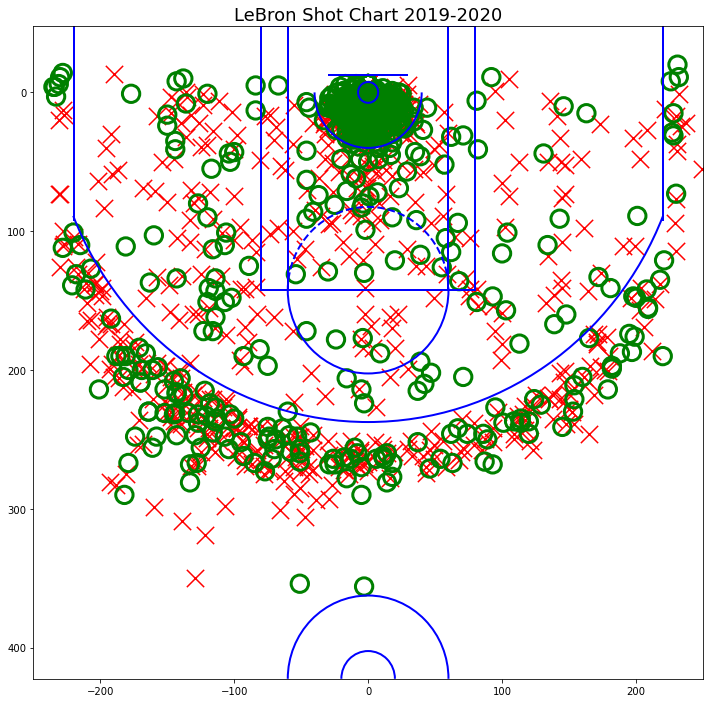

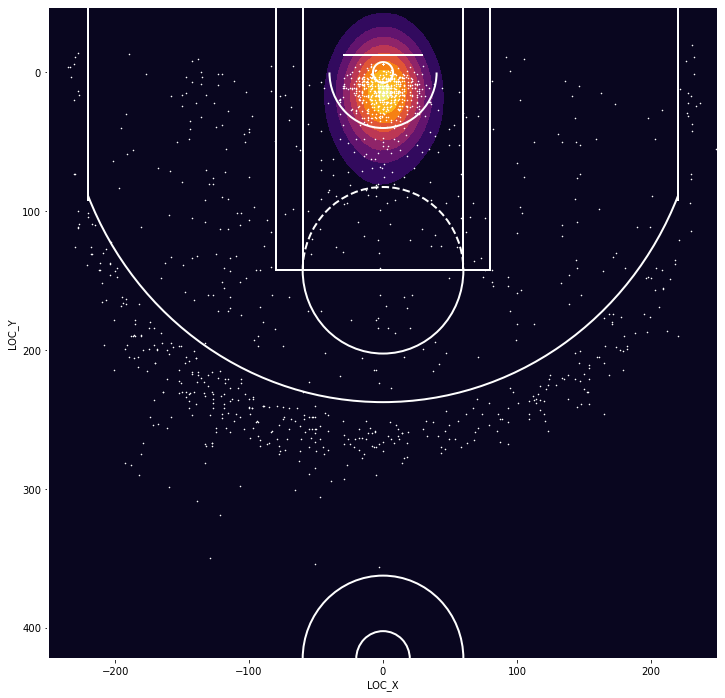

In [69]:
if __name__ == "__main__":
    
    shot_data = get_player_shotchartdetail("LeBron James", "2019-20")
    
    shot_chart(shot_data[0], title="LeBron Shot Chart 2019-2020")
    #store_player_data(shot_data)
    
    #set size for plots
    plt.rcParams['figure.figsize'] = (12,12)
    plt.show()
    
    heatmap(player_shotchart_df)

REFERENCES:

Player Data - https://github.com/swar/nba_api
Court Dimesions - https://github.com/savvastj/nbashots